In [1]:
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
import plotly.graph_objects as go
import collections
import gym
import matplotlib.pyplot as plt
from gym_anytrading.datasets import STOCKS_GOOGL
import ptan
from typing import List, Optional, Tuple, Any

In [2]:
custom_env = gym.make(
        'stocks-v0',
        df = STOCKS_GOOGL,
        window_size = 10,
        frame_bound = (10, 300)
    )

print("custom_env information:")
print("> shape:", custom_env.shape)
print("> df.shape:", custom_env.df.shape)
print("> prices.shape:", custom_env.prices.shape)
print("> signal_features.shape:", custom_env.signal_features.shape)
print("> max_possible_profit:", custom_env.max_possible_profit())

custom_env information:
> shape: (10, 2)
> df.shape: (2335, 6)
> prices.shape: (300,)
> signal_features.shape: (300, 2)
> max_possible_profit: 5.19197248193094


In [3]:
custom_env.df.head(5)

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2009-05-22,198.528534,199.524521,196.196198,196.946945,196.946945,3433700
2009-05-26,196.171173,202.702698,195.195190,202.382385,202.382385,6202700
2009-05-27,203.023026,206.136139,202.607605,202.982986,202.982986,6062500
2009-05-28,204.544540,206.016022,202.507507,205.405411,205.405411,5332200
2009-05-29,206.261261,208.823822,205.555557,208.823822,208.823822,5291100


[[202.382385   5.43544 ]
 [202.982986   0.600601]
 [205.405411   2.422425]
 [208.823822   3.418411]
 [213.4935     4.669678]
 [214.414413   0.920913]
 [216.041046   1.626633]
 [220.360367   4.319321]
 [222.382385   2.022018]
 [219.604599  -2.777786]]


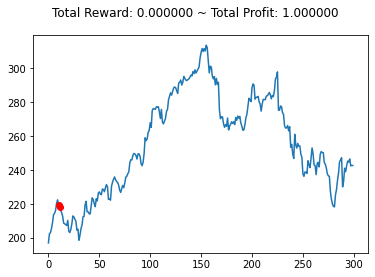

In [4]:
observation = custom_env.reset()
n_steps = 0
while True:
    action = custom_env.action_space.sample()
    observation, reward, done, info = custom_env.step(action)
    print(observation)
    break
    n_steps += 1
    if done:
        print("Info:", info)
        print(f'n_steps: {n_steps}')
        break

plt.cla()
custom_env.render_all()
plt.show()

In [5]:
class ToyEnv(gym.Env): 
    def __init__(self): 
        super(ToyEnv, self).__init__()
        self.observation_space = gym.spaces.Discrete(n=5) 
        self.action_space = gym.spaces.Discrete(n=3)
        self.step_index = 0 
    
    def reset(self): 
        self.step_index = 0 
        return self.step_index 
        
    def step(self, action): 
        is_done = self.step_index == 10 
        if is_done: 
            return (
                self.step_index % self.observation_space.n, 
                0.0, 
                is_done, 
                {}
            )
        self.step_index += 1 
        return (
            self.step_index % self.observation_space.n, 
            float(action), 
            self.step_index == 10, 
            {}
        )


In [ ]:
class DullAgent(ptan.agent.BaseAgent): 
    """ Agent always returns the fixed action """ 
    def __init__(self, action: int): 
        self.action = action 
    
    def __call__(self, observations: List[Any], state: Optional[List] = None) -> Tuple[List[int], Optional[List]]: 
        return [self.action for _ in observations], state


In [ ]:
env = ToyEnv()
agent = DullAgent(action=1)
# exp_source = ptan.experience.ExperienceSource(
#     env=[env],
#     agent=agent,
#     steps_count=2,
# )
exp_source = ptan.experience.ExperienceSourceFirstLast(
    env=[env],
    agent=agent,
    steps_count=2,
    gamma=1.0
)
buffer = ptan.experience.ExperienceReplayBuffer(exp_source, 10)

In [ ]:
for idx, exp in enumerate(exp_source):
    if idx >= 10:
        break

    print(f'{idx}: ({len(exp)} steps)')
    # for step in exp:
    #     print(step)
    print(exp)
    print('\n')

In [ ]:
buffer.populate(1)

In [ ]:
buffer.buffer

In [ ]:
buffer.sample(2)

In [ ]:
def preprocess_raw(filepath: str, save_hdf=False):
    stock_data = pd.read_csv(filepath, sep=',')
    stock_data.columns = [old_n.replace('<', '').replace('>', '').lower() for old_n in stock_data.columns]
    stock_data['date'] = stock_data['date'].astype('str')
    stock_data['time'] = stock_data['time'].astype('str')
    # stock_data.date = pd.to_datetime(stock_data.date, format=r'%Y%m%d')
    stock_data['datetime'] = stock_data.apply(lambda x: pd.to_datetime(x['date'] + x['time'], format=r'%Y%m%d%H%M%S'), axis=1)
    stock_data.drop(columns=['date', 'time'], inplace=True)
    stock_data = stock_data.set_index('datetime')
    if save_hdf:
        stock_data.to_hdf(f'{filepath.split(".csv")[0]}.hdf', key='df')

    return stock_data

In [ ]:
# stock_data = preprocess_raw('Chapter08/data/YNDX_150101_151231.csv', save_hdf=True)
# stock_data = preprocess_raw('Chapter08/data/YNDX_160101_161231.csv', save_hdf=True)

In [ ]:
stock_data = pd.read_hdf('Chapter08/data/YNDX_150101_151231.hdf')
stock_data.head(5)

In [ ]:
fig = go.Figure(
        data=[
            go.Candlestick(
                x=stock_data.index,
                open=stock_data['open'],
                high=stock_data['high'],
                low=stock_data['low'],
                close=stock_data['close']
            )
        ],
    )

fig.update_layout(xaxis_rangeslider_visible=False)
fig.show()

In [ ]:
from tensorforce import Agent, Environment

# Pre-defined or custom environment
environment = Environment.create(
    environment='gym', level='CartPole-v0', max_episode_timesteps=500
)

# Instantiate a Tensorforce agent
agent = Agent.create(
    agent='tensorforce',
    environment=environment,  # alternatively: states, actions, (max_episode_timesteps)
    memory=10000,
    update=dict(unit='timesteps', batch_size=64),
    optimizer=dict(type='adam', learning_rate=3e-4),
    policy=dict(network='auto'),
    objective='policy_gradient',
    reward_estimation=dict(horizon=20)
)

# Train for 300 episodes
for _ in range(300):

    # Initialize episode
    states = environment.reset()
    terminal = False

    while not terminal:
        # Episode timestep
        actions = agent.act(states=states)
        states, terminal, reward = environment.execute(actions=actions)
        agent.observe(terminal=terminal, reward=reward)

agent.close()
environment.close()